In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. READ AND CONCATENATE
df_2009_2010 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2010_2011 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
print("Data size after concatenation:", df.shape)

# 2. DROP MISSING / INVALID
df.dropna(subset=['InvoiceDate', 'Quantity', 'Price'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df.dropna(subset=['InvoiceDate'], inplace=True)

# Remove rows with non-positive Quantity or Price
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

# 3. COMPUTE 'sales'
df['sales'] = df['Quantity'] * df['Price']

# 4. INSPECT TIME RANGE
df.set_index('InvoiceDate', inplace=True)
print("Earliest date (post-clean):", df.index.min())
print("Latest date (post-clean):", df.index.max())
print("Data size after cleaning:", df.shape)

# 5. GROUP BY 'StockCode' TO SEE MONTH PRESENCE
#    (Reset index so we can create 'year_month' from 'InvoiceDate')
df.reset_index(inplace=True)
df['year_month'] = df['InvoiceDate'].dt.to_period('M')

product_month_counts = (
    df.groupby('StockCode')['year_month']
      .nunique()
      .reset_index(name='num_months_present')
)

# Sort so we can see the fewest to most
product_month_counts.sort_values(by='num_months_present', ascending=True, inplace=True)

# Show the first 20
print("\n===== product_month_counts (first 20) =====")
print(product_month_counts.head(20))


Data size after concatenation: (1067371, 8)
Earliest date (post-clean): 2009-12-01 07:45:00
Latest date (post-clean): 2011-12-09 12:50:00
Data size after cleaning: (1041671, 8)

===== product_month_counts (first 20) =====
     StockCode  num_months_present
661      21409                   1
3756    47594a                   1
336      21008                   1
3759    48173A                   1
3763    51012L                   1
3767    51014c                   1
3780    71101A                   1
3794    72084B                   1
3806    72529w                   1
3753    47593b                   1
319      20987                   1
3816    72751A                   1
3817    72751B                   1
3818    72751C                   1
3819    72752A                   1
3820    72752B                   1
2634     23617                   1
3827    72754D                   1
3831    72771B                   1
3811    72740B                   1


In [ ]:
# 6. SHOW DISTRIBUTION AS A TABLE (value_counts)
month_distribution = product_month_counts['num_months_present'].value_counts().sort_index()

print("\n===== Distribution of Products by Months Present =====")
print(month_distribution)




===== Distribution of Products by Months Present =====
num_months_present
1     260
2     194
3     239
4     262
5     155
6     165
7     236
8     193
9     173
10    149
11    118
12    142
13    167
14    165
15    163
16    174
17    123
18    126
19    111
20    155
21    154
22    212
23    162
24    240
25    679
Name: count, dtype: int64


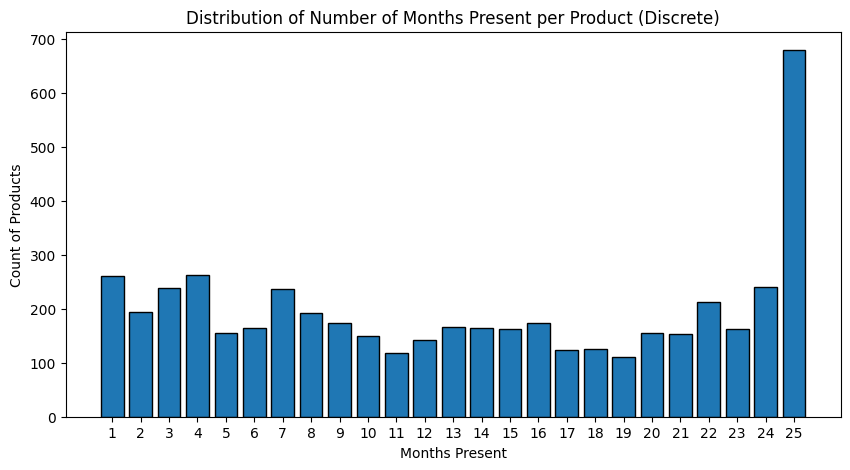

In [ ]:
# 7. PLOT WITHOUT GAPS (BAR CHART WITH DISCRETE X)
#    Explanation of "gaps":
#    - If you do a normal histogram with bins=30, it lumps ranges together.
#    - If some bins have no data, you might see 'blank' areas.
#    - A bar chart with discrete x-values from 1..max_months avoids that.

# Create a complete integer range from 1 up to the max months
max_months = product_month_counts['num_months_present'].max()
all_months = range(1, max_months + 1)

# Convert the 'month_distribution' Series into a full range (filling missing with 0)
month_dist_full = pd.Series(0, index=all_months, dtype=int)
for months, count in month_distribution.items():
    month_dist_full.loc[months] = count

plt.figure(figsize=(10,5))
plt.bar(month_dist_full.index, month_dist_full.values, width=0.8, edgecolor='black')
plt.title("Distribution of Number of Months Present per Product (Discrete)")
plt.xlabel("Months Present")
plt.ylabel("Count of Products")
plt.xticks(month_dist_full.index)  # So each integer from 1..max is labeled
plt.show()

In [ ]:
# 8. FILTER OUT PRODUCTS APPEARING < 6 MONTHS
threshold = 6
valid_stockcodes = product_month_counts[
    product_month_counts['num_months_present'] >= threshold
]['StockCode']

df_filtered = df[df['StockCode'].isin(valid_stockcodes)]

print(f"\nData size before filtering: {df.shape}")
print(f"Data size after filtering (>= {threshold} months): {df_filtered.shape}")

df_filtered.to_csv("filtered_6_months.csv", index=False)
print("Exported filtered dataset to 'filtered_6_months.csv'.")

# 9. RESAMPLE MONTHLY & CREATE LAG FEATURES
df_filtered.set_index('InvoiceDate', inplace=True)
monthly_df = df_filtered.resample('M').sum(numeric_only=True)

monthly_sales = monthly_df[['sales']].copy()

monthly_sales['sales_lag1'] = monthly_sales['sales'].shift(1)
monthly_sales['sales_lag2'] = monthly_sales['sales'].shift(2)
monthly_sales['sales_lag3'] = monthly_sales['sales'].shift(3)

monthly_sales['rolling_mean_3'] = monthly_sales['sales'].rolling(window=3).mean()
monthly_sales['rolling_mean_6'] = monthly_sales['sales'].rolling(window=6).mean()

# 10. EXPORT MONTHLY SALES WITH LAGS
monthly_sales.to_csv("monthly_sales_with_lags.csv")
print("Exported monthly sales (with lags/rolling) to 'monthly_sales_with_lags.csv'.")


Data size before filtering: (1041671, 10)
Data size after filtering (>= 6 months): (1006251, 10)
Exported filtered dataset to 'filtered_6_months.csv'.


/var/folders/l3/vlk20g750bs6_yslnkhmjn5w0000gn/T/ipykernel_51711/2798847251.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df_filtered.resample('M').sum(numeric_only=True)


Exported monthly sales (with lags/rolling) to 'monthly_sales_with_lags.csv'.


In [ ]:
import pandas as pd

# Read data from both sheets of online_retail_II.xlsx
df_2009_2010 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2010_2011 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

# Concatenate the two DataFrames
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)

# Extract unique descriptions from the 'Description' column
unique_descriptions = df['Description'].drop_duplicates()

# Export the unique descriptions to a CSV file without the index column
unique_descriptions.to_csv("unique_description_export.csv", index=False)

print("Successfully exported unique descriptions to 'unique_description_export.csv'")

Successfully exported unique descriptions to 'unique_description_export.csv'


In [ ]:
import pandas as pd

def classify_description(desc):
    """
    Categorize each item description into one of the following:

    1)  Holiday_Seasonal   (Christmas, Easter, Valentine’s, Halloween, etc.)
    2)  Kids_Toys          (Children’s toys, puzzles, stuffed toys, etc.)
    3)  Pet_Supplies       (Items related to pets, e.g. dog bowls, cat bowls, collars)
    4)  Candy_Food         (Candies, chocolates, cookies, snacks, etc.)
    5)  Fashion_Jewelry    (Apparel & jewelry: scarves, hats, bracelets, necklaces, etc.)
    6)  Bags_Accessories   (Bags and accessories: purses, luggage tags, key rings, etc.)
    7)  Stationery_Crafts  (Stationery & crafts: pens, paper, tape, stickers, sewing, etc.)
    8)  Home_Decor         (Home décor: candles, frames, mirrors, doormats, signs, etc.)
    9)  Storage_Organizers (Storage and organizing: boxes, baskets, cabinets, jars, etc.)
    10) Kitchen_Dining     (Kitchen & dining ware: mugs, plates, bowls, utensils, etc.)
    11) Textiles_Bath      (Household linens & bath: towels, hot water bottles, etc.)
    12) Lighting           (Lighting fixtures: lamps, lanterns, string lights, etc.)
    13) Garden_Outdoor     (Garden & outdoor: watering cans, birdhouses, lawn décor, etc.)
    14) System_Log         (System logs or manual adjustments: “discount,” “damaged,” etc.)
    15) Other              (Fallback if no match is found)
    """

    # Convert description to lowercase string for easy matching
    desc_lower = str(desc).lower().strip()

    # --- 14) System_Log first: if any system/log-like keyword is found, classify immediately ---
    # This helps capture manual records, adjustments, errors, etc.
    system_keywords = [
        "manual", "discount", "damages", "damage", "lost", "missing",
        "found", "adjustment", "adjust", "temp", "check", "samples",
        "display", "system log", "error", "wrongly", "invc", "credit",
        "rusty", "wet", "mouldy", "stock", "thrown away", "unsellable",
        "donated", "sale error", "???"  # You can expand further if you see more patterns
    ]
    for kw in system_keywords:
        if kw in desc_lower:
            return "System_Log"

    # --- 1) Holiday_Seasonal ---
    if any(x in desc_lower for x in [
        "christmas", "xmas", "noel", "reindeer", "santa", "bauble", "stocking",
        "snowflake", "wreath", "halloween", "valentine", "easter", "skull",
        "holly", "mistletoe", "turkey", "pudding", "icicle", "holiday",
        "gingerbread", "x-mas", "nativity", "tinsel", "egg hunt"
    ]):
        return "Holiday_Seasonal"

    # --- 2) Kids_Toys ---
    if any(x in desc_lower for x in [
        "kid", "child", "children", "toy", "puzzle", "jigsaw", "puppet",
        "play ", "soft toy", "stuffed toy", "sock puppet", "backpack kids",
        "children's", "lunchbox with cutlery", "space boy", "dolly girl", "nursery"
    ]):
        return "Kids_Toys"

    # --- 3) Pet_Supplies ---
    if any(x in desc_lower for x in [
        "pet", "dog ", "cat ", "kitty", "puppy", "dog bowl", "cat bowl",
        "dog collar", "dog lead", "pet bowl", "bird feeder", "bird house"
    ]):
        return "Pet_Supplies"

    # --- 4) Candy_Food ---
    if any(x in desc_lower for x in [
        "chocolate", "candy", "biscuits", "biscuit", "sweets", "sweeties",
        "marshmallow", "popcorn", "food ", "fudge", "gingerbread",
        "lollipop", "cake mix"
    ]):
        return "Candy_Food"

    # --- 5) Fashion_Jewelry ---
    if any(x in desc_lower for x in [
        "bracelet", "necklace", "earring", "ring ", "brooch", "scarf",
        "ear muff", "poncho", "hair band", "hair comb", "hair slide",
        "hair clip", "glove", "hat ", "beanie", "earphone case",
        "dress jewellery", "fashion"
    ]):
        return "Fashion_Jewelry"

    # --- 6) Bags_Accessories ---
    if any(x in desc_lower for x in [
        " bag", "bags", "purse", "wallet", "tote", "washbag",
        "key ring", "keyring", "luggage tag", "passport cover",
        "shopping bag", "charlotte bag", "shoulder bag", "coin purse"
    ]):
        return "Bags_Accessories"

    # --- 7) Stationery_Crafts ---
    if any(x in desc_lower for x in [
        "notebook", "sticker", "magnet", "wrap", "ribbon", "tissue", "sewing kit",
        "knitting", "crochet", "feltcraft", "paper ", "card ", "doily", "craft",
        "gift tag", "gift box", "paper chain", "glitter", "washi", "stamp",
        "tape measure", "tape ", "eraser", "pencil", "pen ", "journal",
        "scrapbook", "stationery", "invitation"
    ]):
        return "Stationery_Crafts"

    # --- 8) Home_Decor ---
    if any(x in desc_lower for x in [
        "candle", "candles", "t-light", "tealight", "photo frame", "frame",
        "mirror", "doormat", "door mat", "sign", "clock", "hook", "wall art",
        "doorstop", "ornament", "decoration", "tin sign", "door hanger",
        "door sign", "figurine", "vase", "placemat", "door stop", "bunting",
        "coir", "flower garland", "metal sign", "letter rack", "blackboard"
    ]):
        return "Home_Decor"

    # --- 9) Storage_Organizers ---
    if any(x in desc_lower for x in [
        "storage", "organiser", "organizer", "cabinet", "drawer", "crate",
        "rack", "shelf", "box", "basket", "caddy", "chest", "tins",
        "waste bin", "hat box", "wardrobe", "cupboard"
    ]):
        return "Storage_Organizers"

    # --- 10) Kitchen_Dining ---
    if any(x in desc_lower for x in [
        "mug", "cup ", "plate", "bowl", "cutlery", "egg cup", "milk jug",
        "napkin", "tin ", "jar ", "dish", "cake stand", "coaster",
        "bottle opener", "teapot", "kettle", "spoon", "fork", "knife",
        "tray", "food container", "chopstick", "pan ", "jug ", "coffee",
        "tea ", "baking set", "oven glove", "apron", "thermometer",
        "butter dish", "condiment", "jam bowl", "milk pan", "cooking",
        "kitchen"
    ]):
        return "Kitchen_Dining"

    # --- 11) Textiles_Bath ---
    if any(x in desc_lower for x in [
        "towel", "bath ", "shower", "hot water bottle", "flannel", "soap holder",
        "rug ", "blanket", "quilt", "throw", "cushion", "pillow",
        "knitted mug cosy", "oven mitt", "laundry bag", "apron towel",
        "bathroom"
    ]):
        return "Textiles_Bath"

    # --- 12) Lighting ---
    if any(x in desc_lower for x in [
        "light", "lights", "lamp", "lantern", "torch", "bulb", "fairy light",
        "night light", "string light", "led", "chilli lights", "neon",
        "lamp shade", "mosaic candle holder", "spotlight"
    ]):
        return "Lighting"

    # --- 13) Garden_Outdoor ---
    if any(x in desc_lower for x in [
        "garden", "outdoor", "gnome", "watering can", "bird bath", "bird feeder",
        "birdhouse", "seed ", "hammock", "parasol", "plant pot", "greenhouse",
        "wheelbarrow", "patio", "windchime", "flower pot", "terrarium"
    ]):
        return "Garden_Outdoor"

    # If none of the above categories match, return "Other"
    return "Other"


def main():
    """
    Main function to:
      1) Read the CSV file.
      2) Classify each row using the classify_description() function.
      3) Print category distribution.
      4) Export each category subset to its own CSV file.
    """
    # 1) Read the CSV file (adjust filename to match your environment)
    df = pd.read_csv("filtered_6_months(use later).csv")

    # 2) Apply classification to each row in 'Description'
    df['Category'] = df['Description'].apply(classify_description)

    # 3) Get counts per category
    cat_counts = df['Category'].value_counts(dropna=False)
    print("\n=== Category Distribution ===")
    print(cat_counts)

    # 4) Check how many rows ended up in 'Other'
    other_count = cat_counts.get('Other', 0)
    print(f"\nNumber of rows in 'Other': {other_count}")

    # 5) Export each category into a separate CSV file
    unique_cats = df['Category'].unique()
    for cat in unique_cats:
        subset = df[df['Category'] == cat]
        # Replace slashes/spaces in category names to make valid filenames
        fname = cat.replace("/", "_").replace(" ", "_") + ".csv"
        subset.to_csv(fname, index=False, encoding='utf-8')
        print(f"Exported {len(subset)} rows to {fname}")

if __name__ == "__main__":
    main()


/var/folders/l3/vlk20g750bs6_yslnkhmjn5w0000gn/T/ipykernel_51711/850853192.py:167: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filtered_6_months(use later).csv")



=== Category Distribution ===
Category
Home_Decor            203323
Other                 199649
Stationery_Crafts     116592
Kitchen_Dining         99961
Bags_Accessories       88651
Holiday_Seasonal       74580
Storage_Organizers     67727
Kids_Toys              37995
Fashion_Jewelry        27876
Candy_Food             23058
Textiles_Bath          22163
Lighting               15589
Garden_Outdoor         12998
Pet_Supplies           12915
System_Log              3174
Name: count, dtype: int64

Number of rows in 'Other': 199649
Exported 74580 rows to Holiday_Seasonal.csv
Exported 15589 rows to Lighting.csv
Exported 203323 rows to Home_Decor.csv
Exported 67727 rows to Storage_Organizers.csv
Exported 199649 rows to Other.csv
Exported 99961 rows to Kitchen_Dining.csv
Exported 12915 rows to Pet_Supplies.csv
Exported 27876 rows to Fashion_Jewelry.csv
Exported 37995 rows to Kids_Toys.csv
Exported 22163 rows to Textiles_Bath.csv
Exported 23058 rows to Candy_Food.csv
Exported 3174 rows to Sy